In [1]:
import logging
import numpy
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *
from full_acf_cuf_classification_final import *

In [2]:
data = pd.read_csv('RAIdata.csv')

In [3]:
data.drop(columns="Unnamed: 0", inplace=True)

In [4]:
data.head()

,Age,AppliedAmount,DebtToIncome,ExpectedLoss,LiabilitiesTotal,FreeCash,IncomeFromChildSupport,IncomeFromFamilyAllowance,IncomeFromLeavePay,IncomeFromPension,...,VerificationType_2.0,VerificationType_3.0,VerificationType_4.0,WorkExperience_10To15Years,WorkExperience_15To25Years,WorkExperience_2To5Years,WorkExperience_5To10Years,WorkExperience_LessThan2Years,WorkExperience_MoreThan25Years,Young
0,54.0,8505.0,0.0,0.118622,87.82,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,52.0,2230.0,0.0,0.059200,309.23,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,28.0,530.0,0.0,0.048764,143.58,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,40.0,1380.0,0.0,0.071894,70.65,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,31.0,530.0,0.0,0.043700,719.42,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,1


### Full Model - With Sensitive Features

In [5]:
# Gender_1.0 = Male, MaritalStatus_1.0 = Married, LanguageCode_1 = Estonian
data_acf_log = data[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 
                     'IncomeTotal','Interest', 'LoanDuration', 'MonthlyPayment', 'Gender_1.0',
                     'MaritalStatus_1.0','LanguageCode_1', 'NrOfDependantslessthan3']]

In [6]:
target_variable = "Default"
protected_features = ['Gender_1.0','MaritalStatus_1.0','LanguageCode_1','NrOfDependantslessthan3']
independent_features = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal','IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment']

In [7]:
for col in data_acf_log.columns:
    if data_acf_log.isnull().sum()[col]!=0:
        data_acf_log[col].fillna((data_acf_log[col].mean()), inplace=True)  

In [8]:
full_model = Generic(data_acf_log,protected_features,independent_features,target_variable,False) # initializing object with data and features
full_model.fit() # fitting the model 
full_model_predictions = full_model.predict() # predicting using model
full_model_pred_probs = full_model.predict_proba() # predicting probabilities using model
full_model_metrics = full_model.get_model_metrics() # ROC AUC Score
fm_fairness_metrics = full_model.get_fairness_metrics() # equal odds, demographic parity, predictive parity
fm_model_metrics_diff = full_model.get_model_metrics_difference() # difference in model metrics between two groups of each feature

In [9]:
print("Fairness Metrics for Full Model with sensitive features") # equal odds, demographic parity, predictive parity
fm_fairness_metrics

Fairness Metrics for Full Model with sensitive features


,Column,Equal Odds (Full Model with sensitive features),Demographic Parity (Full Model with sensitive features),Predictive Parity (Full Model with sensitive features)
0,Gender_1.0,0.051471,0.024067,0.019140
1,MaritalStatus_1.0,0.288983,0.127875,0.103305
2,LanguageCode_1,0.046099,0.015235,0.152357
3,NrOfDependantslessthan3,0.944578,0.481529,0.058730


In [10]:
print("Difference in Model Metrics for Full Model with sensitive features")
fm_model_metrics_diff

Difference in Model Metrics for Full Model with sensitive features


,Column,ROC AUC Score Difference (Full Model with sensitive features)
0,Gender_1.0,0.000308
1,MaritalStatus_1.0,0.016447
2,LanguageCode_1,0.004332
3,NrOfDependantslessthan3,0.123395


### Full Model - Without Sensitive Features

In [11]:
data_acf_log_2 = data[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 
                     'IncomeTotal','Interest', 'LoanDuration', 'MonthlyPayment']]

In [12]:
for col in data_acf_log_2.columns:
    if data_acf_log_2.isnull().sum()[col]!=0:
        data_acf_log_2[col].fillna((data_acf_log_2[col].mean()), inplace=True)  

In [13]:
y=data_acf_log_2[target_variable]*1000
x=data_acf_log_2.drop(columns=[target_variable])
X_train_2, X_test_2, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=3000)

In [14]:
full_model_2 = Generic(data_acf_log,protected_features,independent_features,target_variable,False,False) # initializing object with data and features
full_model_2.fit(X_train_2) # fitting the model 
full_model_2_predictions = full_model_2.predict(X_test_2) # predicting using model 
full_model_2_pred_probs = full_model_2.predict_proba(X_test_2) # predicting probabilities using model
full_model_2_metrics = full_model_2.get_model_metrics() # ROC AUC Score
fm2_fairness_metrics = full_model_2.get_fairness_metrics() # equal odds, demographic parity, predictive parity
fm2_model_metrics_diff = full_model_2.get_model_metrics_difference() # difference in model metrics between two groups of each feature

In [15]:
print("Fairness Metrics for Full Model without sensitive features") # equal odds, demographic parity, predictive parity
fm2_fairness_metrics

Fairness Metrics for Full Model without sensitive features


,Column,Equal Odds (Full Model without sensitive features),Demographic Parity (Full Model without sensitive features),Predictive Parity (Full Model without sensitive features)
0,Gender_1.0,0.012496,0.008364,0.004202
1,MaritalStatus_1.0,0.063628,0.037145,0.089635
2,LanguageCode_1,0.006087,0.000225,0.248638
3,NrOfDependantslessthan3,0.082708,0.044747,0.305556


In [16]:
print("Difference in Model Metrics for Full Model without sensitive features")
fm2_model_metrics_diff

Difference in Model Metrics for Full Model without sensitive features


,Column,ROC AUC Score Difference (Full Model without sensitive features)
0,Gender_1.0,0.007549
1,MaritalStatus_1.0,0.011307
2,LanguageCode_1,0.002006
3,NrOfDependantslessthan3,0.107007


### ACF Model

In [17]:
ACF = Generic(data_acf_log,protected_features,independent_features,target_variable,True) # initializing object with data and features
df_R_train = ACF.get_residuals_train_data() # getting residuals which are independent of sensitive features - train data
ACF.fit(df_R_train) # fitting the model
df_R_test = ACF.get_residuals_test_data() # getting residuals which are independent of sensitive features - test data
acf_predictions = ACF.predict(df_R_test) # predicting using model 
acf_pred_probs = ACF.predict_proba(df_R_test) # predicting probabilities using model
acf_model_metrics = ACF.get_model_metrics() # ROC AUC Score
acf_fairness_metrics = ACF.get_fairness_metrics() # equal odds, demographic parity, predictive parity
acf_model_metrics_diff = ACF.get_model_metrics_difference() # difference in model metrics between two groups of each feature

In [18]:
print("Fairness Metrics for ACF Model") # equal odds, demographic parity, predictive parity
acf_fairness_metrics

Fairness Metrics for ACF Model


,Column,Equal Odds (ACF Model),Demographic Parity (ACF Model),Predictive Parity (ACF Model)
0,Gender_1.0,0.005487,0.005920,0.078661
1,MaritalStatus_1.0,0.008054,0.019286,0.203200
2,LanguageCode_1,0.002709,0.001302,0.165116
3,NrOfDependantslessthan3,0.009385,0.015026,0.107143


In [19]:
print("Difference in Model Metrics for ACF Model")
acf_model_metrics_diff

Difference in Model Metrics for ACF Model


,Column,ROC AUC Score Difference (ACF Model)
0,Gender_1.0,0.022266
1,MaritalStatus_1.0,0.032737
2,LanguageCode_1,0.002859
3,NrOfDependantslessthan3,0.098838


### Fairness Metrics Comparison

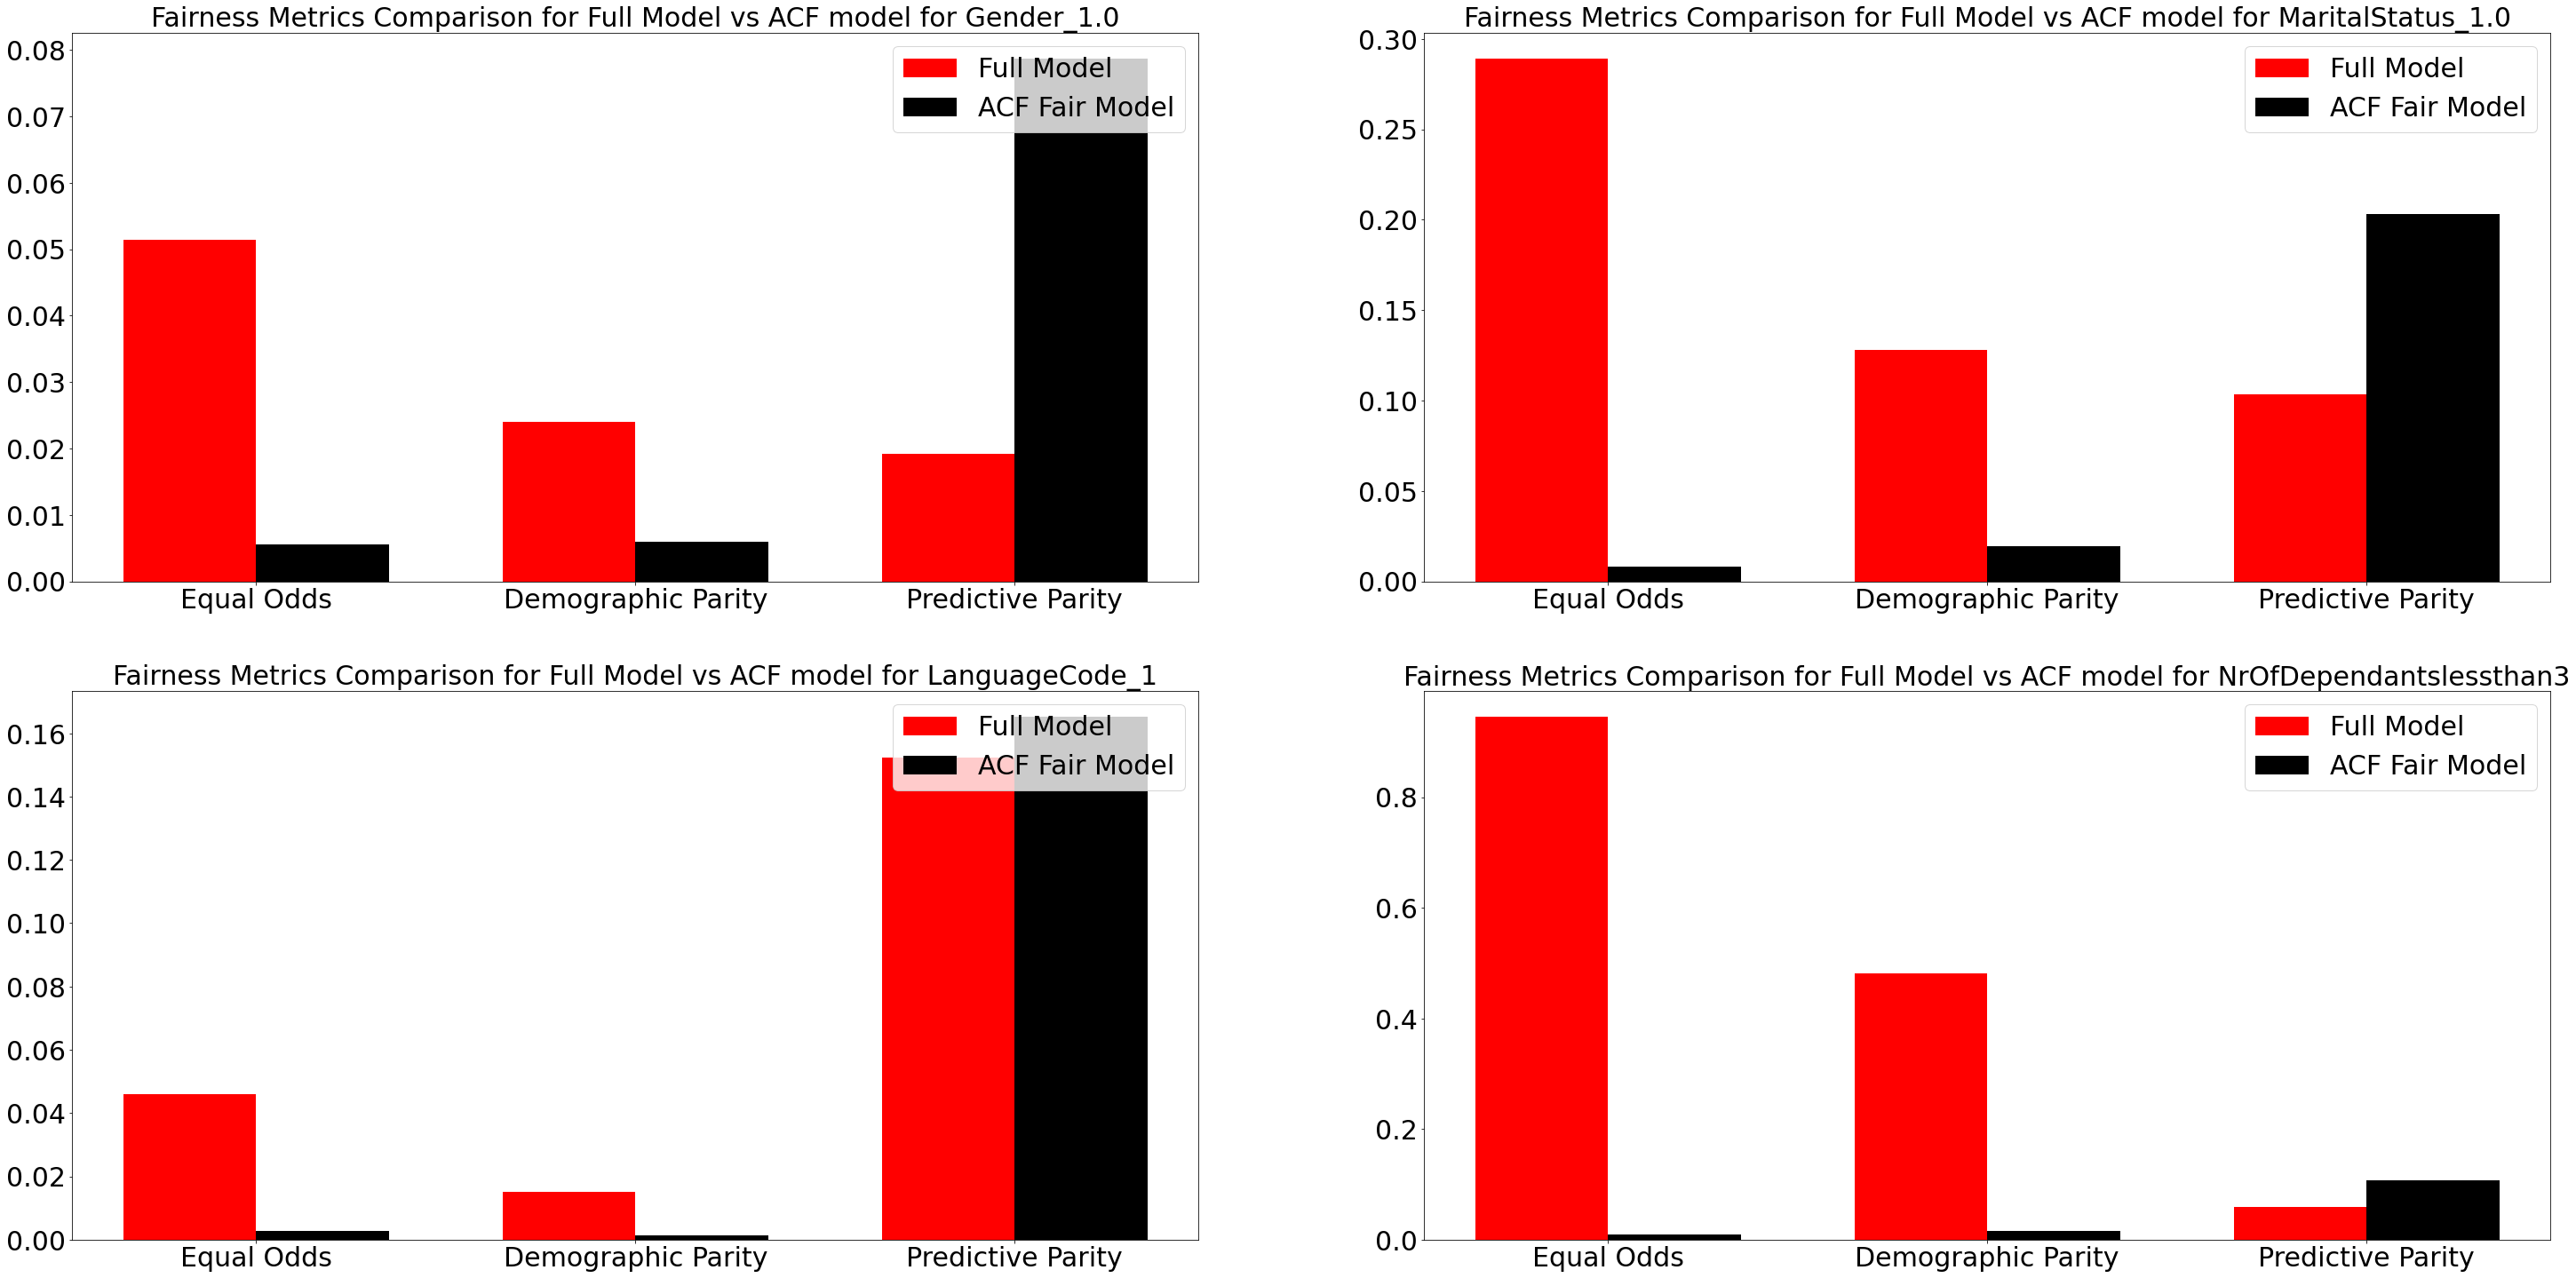

In [20]:
metrics = ["Equal Odds","Demographic Parity","Predictive Parity"]
ACF.get_fairness_metrics_plots(metrics,acf_fairness_metrics,fm_fairness_metrics)

In [21]:
print("Model Metrics for Full Model with sensitive features")
1-full_model_metrics

Model Metrics for Full Model with sensitive features


,ROC AUC Score (Full Model with sensitive features)
0,0.648803


In [22]:
print("Model Metrics for Full Model without sensitive features")
1-full_model_2_metrics

Model Metrics for Full Model without sensitive features


,ROC AUC Score (Full Model without sensitive features)
0,0.640811


In [23]:
print("Model Metrics for ACF Model")
1-acf_model_metrics

Model Metrics for ACF Model


,ROC AUC Score (ACF Model)
0,0.633112


### Error in predicting probabilty of Default Vs Applied Loan Amount

In [24]:
print("Actual VS Predicted for Full Model")
crosstab,total_full_model=full_model.get_crosstab_total_amount(full_model_predictions)
crosstab

Actual VS Predicted for Full Model


Predicted,Non-Defaulter,Defaulter
Actual,,
Non-Defaulter,9247,133
1000.0,2751,134


In [25]:
print("Actual VS Predicted for ACF Model")
crosstab,total_acf=ACF.get_crosstab_total_amount(acf_predictions)
crosstab

Actual VS Predicted for ACF Model


Predicted,Non-Defaulter,Defaulter
Actual,,
Non-Defaulter,9268,112
1000.0,2742,143


In [26]:
print(f"Total Applied Amount for Full Model:{round(total_full_model,3)}")

Total Applied Amount for Full Model:20613423.826


In [34]:
print(f"Total Applied Amount for ACF Model:{round(total_acf,3)}")

Total Applied Amount for ACF Model:20794496.439


### Full Model and ACF Model with Counterfactual Data

<div class="alert alert-block alert-info">
CUF Score: $\frac{1}{n}\sum({E}$ - ${E'})^{2}$
</div>

In [28]:
error = full_model.get_error(full_model_pred_probs)
full_model_counter_factual_data = full_model.get_counterfactual_data()
full_model_pred_probs_CUF = full_model.predict_proba(full_model_counter_factual_data)
full_model_metrics_CUF = full_model.get_model_metrics()
error_counterfactual = full_model.get_error(full_model_pred_probs_CUF)
full_model_CUF_score = (np.sum(np.square(error_counterfactual - error))/len(error))

In [29]:
error_acf = ACF.get_error(acf_pred_probs)
acf_counter_factual_data = ACF.get_counterfactual_data()
df_R_counter_sens_test = ACF.get_residuals_test_data(True)
acf_pred_probs_CUF = ACF.predict_proba(df_R_counter_sens_test)
acf_metrics_CUF = ACF.get_model_metrics()
error_counterfactual_acf = ACF.get_error(acf_pred_probs_CUF)
acf_CUF_score = (np.sum(np.square(error_counterfactual_acf - error_acf))/len(error_acf))

In [30]:
print(f"CUF Score for Full Model: {full_model_CUF_score*1000}")

CUF Score for Full Model: 86.79090383952989


In [31]:
print(f"CUF Score for ACF Model: {acf_CUF_score*1000}")

CUF Score for ACF Model: 2.5078944967310153


<div class="alert alert-block alert-success">
<b>Inference:</b>
    The CUF Score has reduced drastically from 86.79 to 2.51 with the ACF model. This helps us conclude that the implementation of ACF technique is successful in mitigating bias.
</div>

### CUF Visualizations

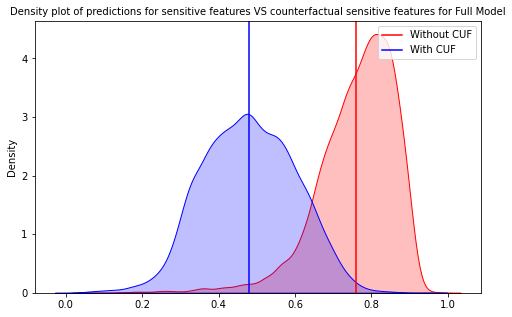

In [32]:
full_model.get_plots_CUF(full_model_pred_probs, full_model_pred_probs_CUF, error, error_counterfactual)

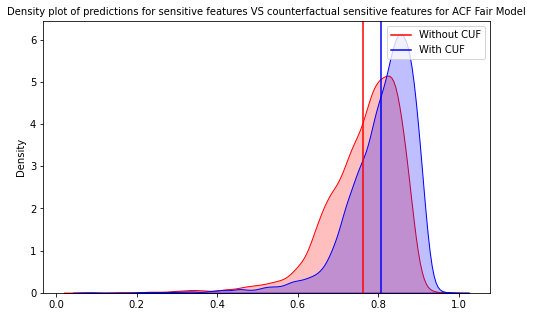

In [33]:
ACF.get_plots_CUF(acf_pred_probs, acf_pred_probs_CUF, error_acf, error_counterfactual_acf)